In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
import datetime as datetime

In [2]:
# Load the data
traincsvFile = pd.read_csv('train.csv')
# Preprocessing
string_columns = traincsvFile.select_dtypes(include=['object']).columns

In [3]:
# Encoding
for column in string_columns:
    unique_strings = traincsvFile[column].unique()
    string_to_index = {string: index for index, string in enumerate(unique_strings)}
    traincsvFile[column] = traincsvFile[column].map(string_to_index)

# Keeping only most important features
X = traincsvFile.drop(columns=['id', 'class', 'stem-root', 'has-ring', 'cap-shape', 'stem-surface',
                               'habitat', 'ring-type', 'season', 'veil-color', 'veil-type', 'spore-print-color'])
Y = traincsvFile['class']

# Encoding labels that aren't numbers
if Y.dtype == 'object':
    le = LabelEncoder()
    Y = le.fit_transform(Y)

In [5]:
# Split
train_split = int(0.5 * Y.size)
val_split = int(0.75 * Y.size)

X_train = X[:train_split]
Y_train = Y[:train_split]

X_val = X[train_split:val_split]
Y_val = Y[train_split:val_split]

X_test = X[val_split:]
Y_test = Y[val_split:]

In [6]:
# Normalization
x_train_mean = X_train.mean(axis=0)
x_train_std = X_train.std(axis=0)

X_train = (X_train - x_train_mean) / x_train_std
X_val = (X_val - x_train_mean) / x_train_std
X_test = (X_test - x_train_mean) / x_train_std

print("Items in training set:", len(X_train))

print("Items in validation set:", len(X_val))

print("Items in test set:", len(X_test))

Items in training set: 1558472
Items in validation set: 779236
Items in test set: 779237


In [7]:
# XGBoost model data splits
dtrain = xgb.DMatrix(X_train, label=Y_train)
dval = xgb.DMatrix(X_val, label=Y_val)
dtest = xgb.DMatrix(X_test, label=Y_test)

# Define XGBoost model
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}

# Train the model
# 100 iterations, early stopping set to 10 rounds
evals = [(dtrain, 'train'), (dval, 'eval')]
bst = xgb.train(
    params, dtrain,
    num_boost_round=100,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	train-logloss:0.64378	eval-logloss:0.64405
[1]	train-logloss:0.60657	eval-logloss:0.60695
[2]	train-logloss:0.57294	eval-logloss:0.57336
[3]	train-logloss:0.53415	eval-logloss:0.53456
[4]	train-logloss:0.51187	eval-logloss:0.51233
[5]	train-logloss:0.49289	eval-logloss:0.49339
[6]	train-logloss:0.46593	eval-logloss:0.46645
[7]	train-logloss:0.44381	eval-logloss:0.44432
[8]	train-logloss:0.42058	eval-logloss:0.42105
[9]	train-logloss:0.40234	eval-logloss:0.40280
[10]	train-logloss:0.38600	eval-logloss:0.38645
[11]	train-logloss:0.36827	eval-logloss:0.36868
[12]	train-logloss:0.35434	eval-logloss:0.35481
[13]	train-logloss:0.34102	eval-logloss:0.34149
[14]	train-logloss:0.32937	eval-logloss:0.32993
[15]	train-logloss:0.31754	eval-logloss:0.31812
[16]	train-logloss:0.30642	eval-logloss:0.30702
[17]	train-logloss:0.29831	eval-logloss:0.29896
[18]	train-logloss:0.28839	eval-logloss:0.28907
[19]	train-logloss:0.27946	eval-logloss:0.28017
[20]	train-logloss:0.27193	eval-logloss:0.27268
[2

Accuracy: 0.9812
ROC-AUC: 0.9946
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    352584
           1       0.98      0.98      0.98    426653

    accuracy                           0.98    779237
   macro avg       0.98      0.98      0.98    779237
weighted avg       0.98      0.98      0.98    779237



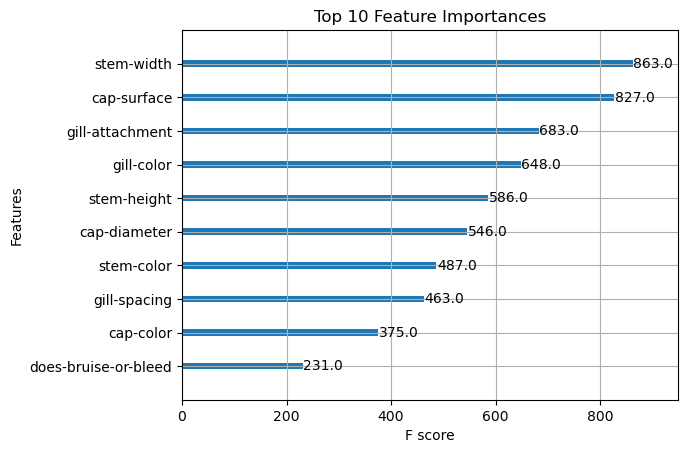

In [8]:
# Predictions on test set
y_pred_prob = bst.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate metrics
accuracy = accuracy_score(Y_test, y_pred)
roc_auc = roc_auc_score(Y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("Classification Report:")
print(classification_report(Y_test, y_pred))

# Feature importance
xgb.plot_importance(bst, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

In [9]:
# Load the Kaggle test dataset
new_test_data = pd.read_csv('test.csv')

In [10]:
# Preprocess
string_columns = new_test_data.select_dtypes(include=['object']).columns

# Encoding
for column in string_columns:
    unique_strings = new_test_data[column].unique()
    string_to_index = {string: index for index, string in enumerate(unique_strings)}
    new_test_data[column] = new_test_data[column].map(string_to_index)

# Drop the same columns here to match (note no class because it is not included in the test data)
X_new_test = new_test_data.drop(columns=['id', 'stem-root', 'has-ring', 'cap-shape', 'stem-surface',
                                         'habitat', 'ring-type', 'season', 'veil-color',
                                         'veil-type', 'spore-print-color'])

In [29]:
# Normalization
X_new_test = (X_new_test - x_train_mean) / x_train_std

dnew_test = xgb.DMatrix(X_new_test)

# Predictions on full test dataset
new_test_predictions = bst.predict(dnew_test)
new_test_binary_predictions = np.array(['p' if x > 0.5 else 'e' for x in new_test_predictions])

In [ ]:
now = datetime.datetime.now()

# Output results to CSV
new_test_data['class'] = new_test_binary_predictions
new_test_data[['id', 'class']].to_csv(f'Finaltest_predictions_{now.strftime("%m-%d_%H-%M-%S")}.csv', index=False)
print("Predictions saved to test_predictions_{timestamp}.csv")

Predictions saved to test_predictions.csv
